In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import torch.nn as nn
from datasets import SineDataset, CosineDataset, SineCosineDataset
from torch.utils.data import ConcatDataset, DataLoader
from tiny.new_diffusion import Diffusion
from tiny.dit import UnconditionalPointCloudDiT
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def plot_point_clouds(point_clouds: torch.Tensor, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.ravel()
    dim = point_clouds.shape[2]
    point_clouds = point_clouds.cpu()

    for idx, ax in enumerate(axes):
        if idx < len(point_clouds):

            if dim == 2:
                X, Y = point_clouds[idx, :, 0], point_clouds[idx, :, 1]
                ax.scatter(X, Y)
            elif dim == 3:
                X, Y, Z = (
                    point_clouds[idx, :, 0],
                    point_clouds[idx, :, 1],
                    point_clouds[idx, :, 2],
                )
                ax.scatter(X, Y, Z)

            ax.axis("equal")  # Ensures that the scale of x and y axes are the same
        else:
            ax.axis("off")  # Turn off axis if there's no data to plot

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

In [4]:
num_points = 128
# dataset = SineCosineDataset(num_points=num_points, size=1024)
sine_dataset = SineDataset(num_points=num_points, size=15000)
cosine_dataset = CosineDataset(num_points=num_points, size=15000)
dataset = sine_dataset
dataset = cosine_dataset
dataset = ConcatDataset([sine_dataset, cosine_dataset])

dataloader = DataLoader(dataset, collate_fn=sine_dataset.collate, batch_size=128, shuffle=True)

In [7]:
diffusion = Diffusion(
    schedule_type="linear",
    num_timesteps=1000
)

model = UnconditionalPointCloudDiT(input_size=num_points, in_channels=2, depth=1, num_heads=1, hidden_size=32).to("cuda")

count_parameters(model)

30658

In [9]:
num_epochs = 5
model = model.to("cuda")
diffusion = diffusion.to("cuda")
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with tqdm(total=num_epochs * len(dataloader)) as pbar:
    for epoch in range(num_epochs):
        for batch in dataloader:
            X = batch["data"].to("cuda")
            t = torch.randint(0, 1000, (X.shape[0],)).long().to("cuda")
            loss = diffusion.training_losses(model, X, t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({"loss": loss.item()})

  1%|          | 11/1175 [00:00<03:23,  5.72it/s, loss=0.878]

100%|██████████| 1175/1175 [00:05<00:00, 209.80it/s, loss=0.122]


 16%|█▌        | 161/1000 [00:00<00:01, 799.93it/s]

100%|██████████| 1000/1000 [00:01<00:00, 802.63it/s]


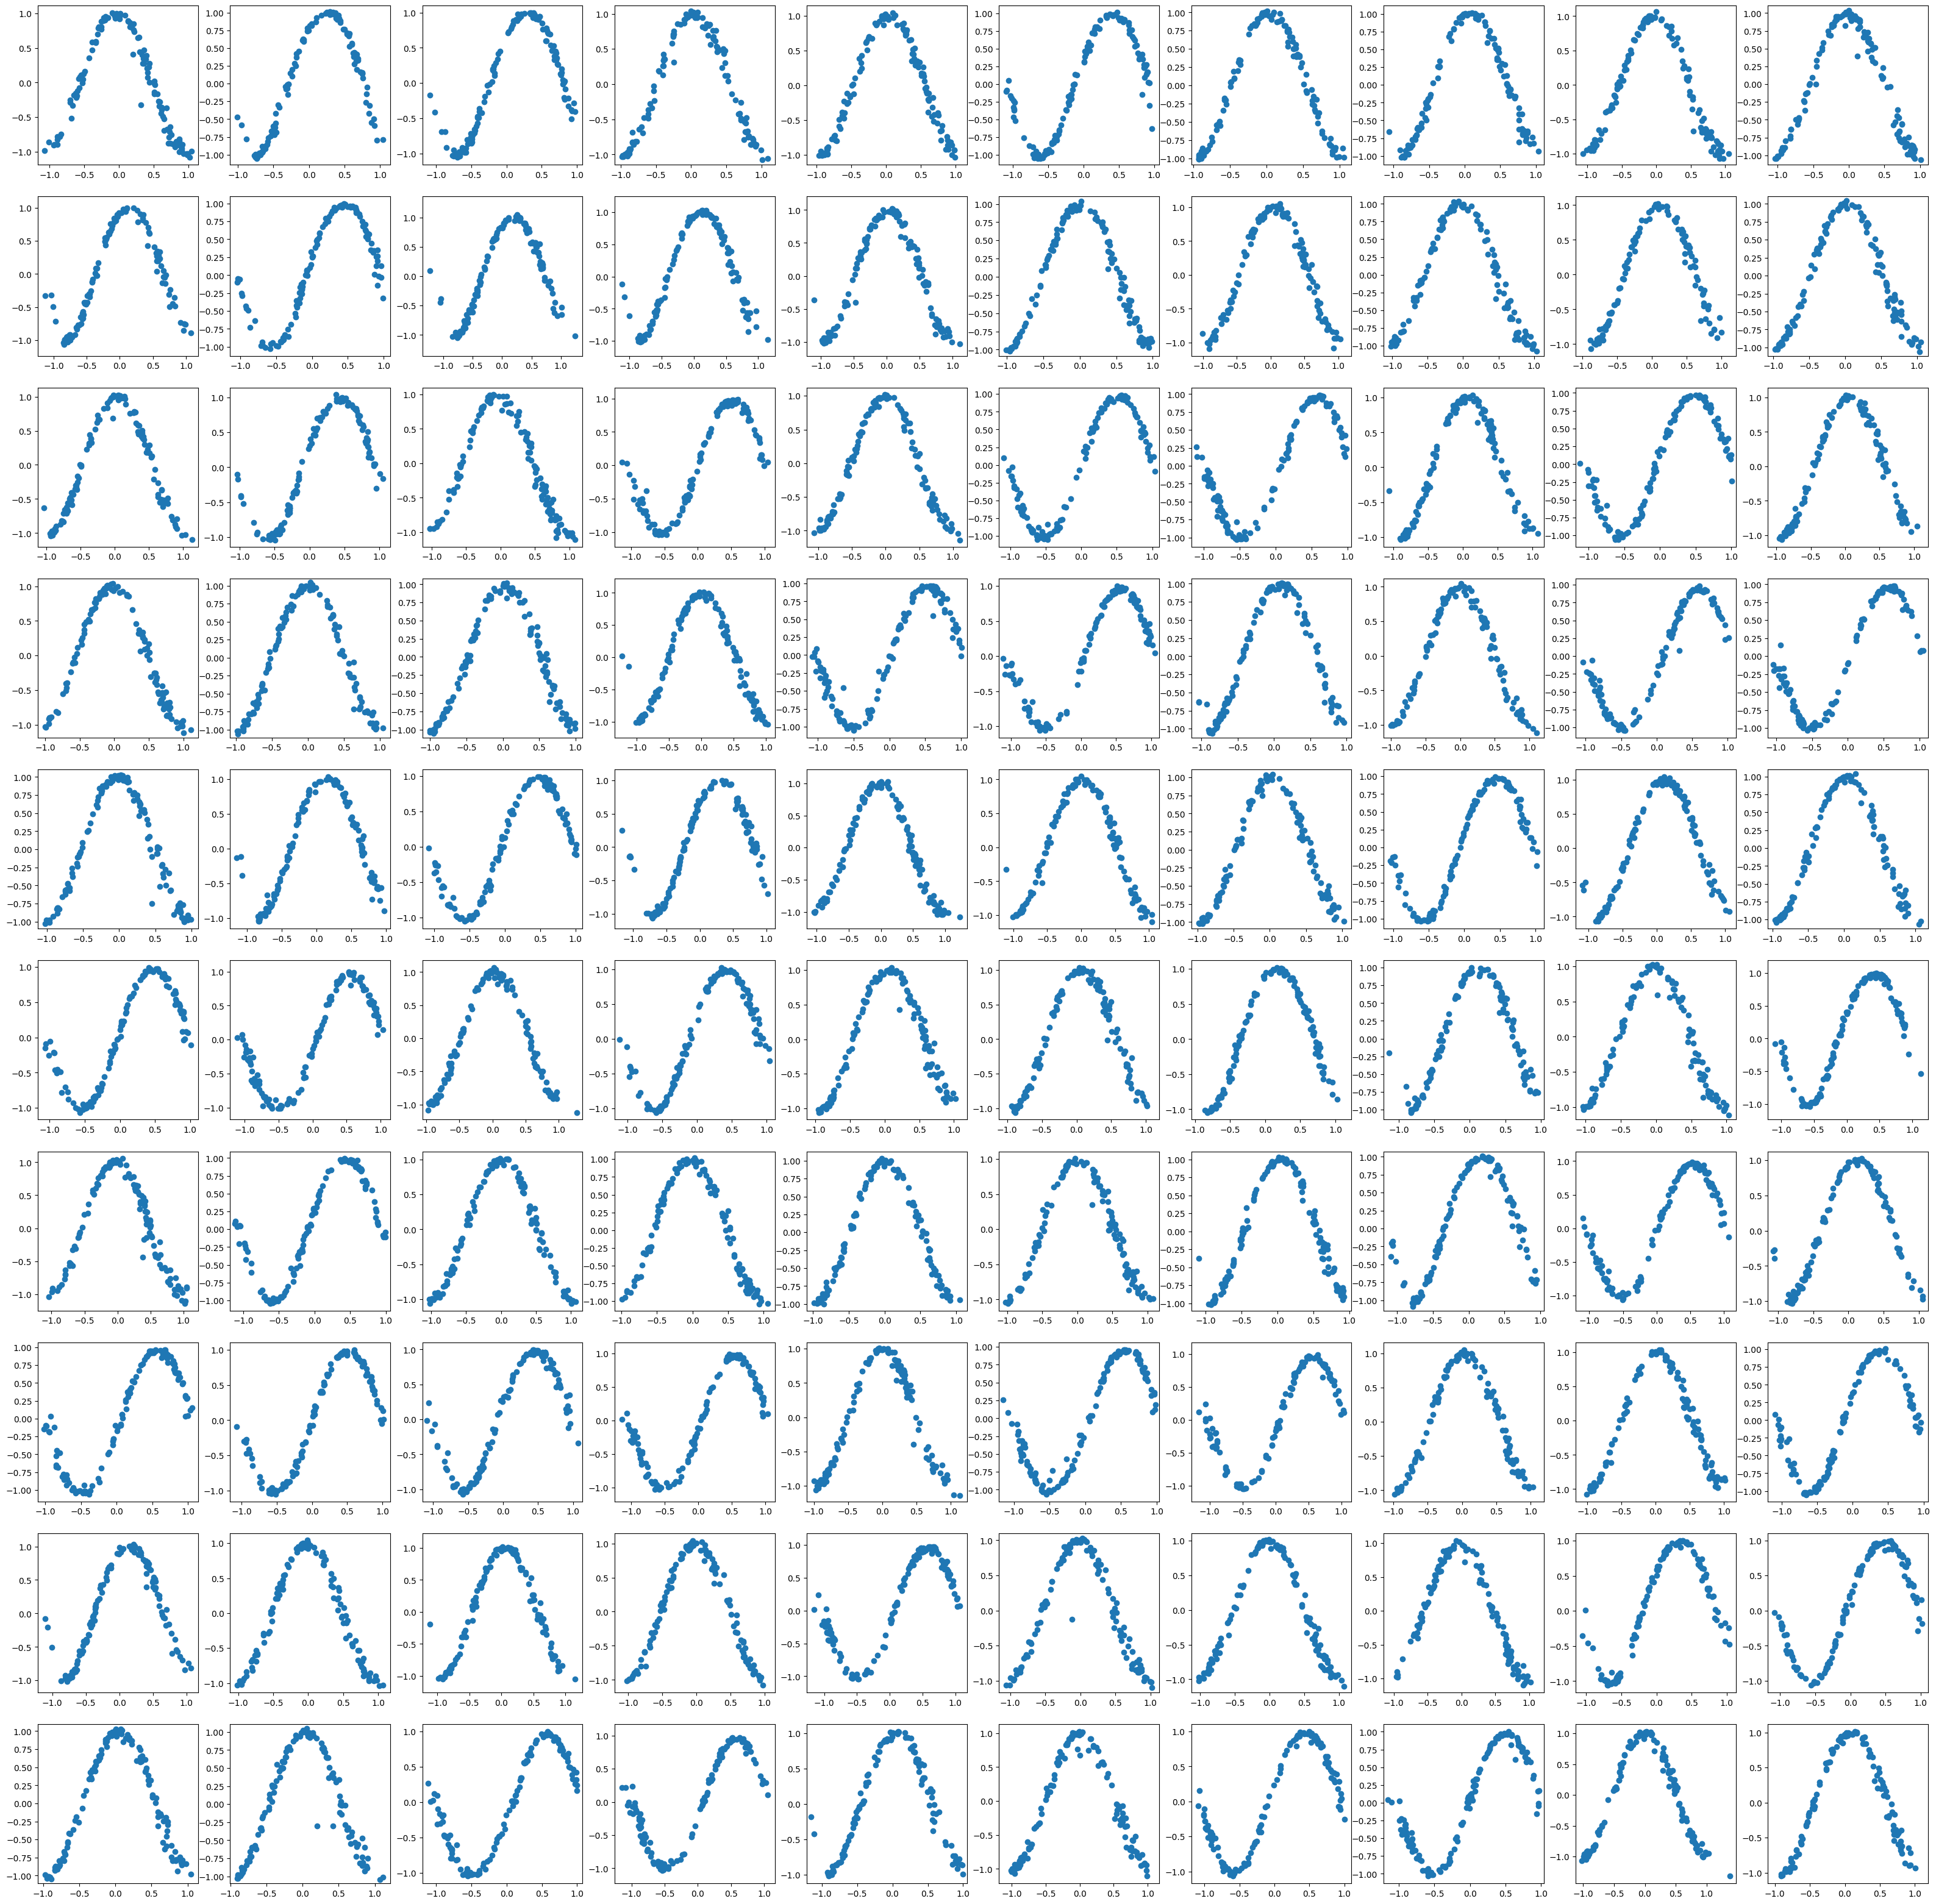

In [11]:
samples = diffusion.p_sample_loop(model, (100, num_points, 2), clip_denoised=False)
plot_point_clouds(samples, 10, 10)